# Part 2: seq2seq model with attention for language translation or chatbot?

## some resources
- [online tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb) and [code](https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation) from practical pytorch
- MaximumEntropy [seq2seq-pytorch](https://github.com/MaximumEntropy/Seq2Seq-PyTorch)
- IBM [pytorch seq2seq](https://github.com/IBM/pytorch-seq2seq)
- [seq2seq.pytorch](https://github.com/eladhoffer/seq2seq.pytorch)
- [seq2seq with tensorflow tutorials](https://github.com/ematvey/tensorflow-seq2seq-tutorials)
- [seq2seq neural machine translation tutorial](https://github.com/tensorflow/nmt)
- [chatbot based on seq2seq antilm](https://github.com/Marsan-Ma/tf_chatbot_seq2seq_antilm)
- [practical seq2seq for chatbot](http://suriyadeepan.github.io/2016-12-31-practical-seq2seq/)

## datasets
- [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)
- [chat corpus](https://github.com/Marsan-Ma/chat_corpus)

It might be too long to fit into one notebook, so split it into several.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import random

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

### Load the language data

In [3]:
PAD, SOS, EOS, UNK = 0, 1, 2, 3

from collections import Counter
import re

# langauge model, aka w2i, i2w, and wc
class Language(object):
    def __init__(self, name, tokenizer):
        self.tokenizer = tokenizer # regular expression
        self.w2i = {"PAD":PAD, "SOS":SOS, "EOS": EOS, "UNK": UNK} # word to index
        self.i2w = {PAD: "PAD", SOS: "SOS", EOS: "EOS", UNK: "UNK"} # index to word
        self.wc = Counter() # word count
        
    def update(self, sentences):
        for sentence in sentences:
            words = re.findall(self.tokenizer, sentence.lower())
            for word in words:
                if word not in self.w2i:
                    self.w2i[word] = len(self.w2i)
                    self.i2w[len(self.i2w)] = word
            self.wc.update(words)
            
    def prune(self, percent):
        pass
    
English = Language("english", u"\\w+|\S")
Chinese = Language("chinese", u".")

In [4]:
lines = open("/home/mali/ws/data/bilingual/cn2en/cmn.txt").readlines()
english_sents, chinese_sents = zip(*[line.split("\t") for line in lines])

English.update(english_sents)
Chinese.update(chinese_sents)

TODO: finish the language translation example. for now focus on simple case like string reversing for illustration and simplicity

### Reversed Seq Data as a simpler example

In [60]:
## generate some data: 
## input - a sequence of integers(index), target: the reverse of it
## for vocabulary setup, reserving index 0 for padding and index 1 for EOS

## this corresponds to skipping the vocab building (word2inex, index2word) and
## use index directly
class ReverseSeqData(data.Dataset):
    def __init__(self, vocab_size=10, max_seq=10, n_data=1000):
        self.vocab_size = vocab_size
        self.max_seq = max_seq
        self.n_data = n_data
        self.seqs = []
        self.seq_lens = []
        for _ in range(n_data):
            seq_len = np.random.randint(2, max_seq)
            seq = np.zeros(max_seq).astype(np.int64)
            seq[:seq_len] = np.random.randint(2, 10, seq_len) # 0, 1 reserved for padding and EOS
            self.seqs.append(seq)
            self.seq_lens.append(seq_len)
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, i):
        seq = self.seqs[i]
        seq_len = self.seq_lens[i]
        target = np.zeros(self.max_seq + 1).astype(np.int64)
        target[:seq_len+1] = np.array([x for x in seq[:seq_len][::-1]] + [1])
        return (seq, target, seq_len)
    
toy_ds = ReverseSeqData(n_data=50000, max_seq=6)

print(len(toy_ds))
s, t, l = toy_ds[0]
print(s, t, l)

50000
[5 9 2 3 0 0] [3 2 9 5 1 0 0] 4


In [61]:
def sort_seqs_by_len(*seqs, lens):
    order = np.argsort(lens)[::-1]
    sorted_seqs = []
    for seq in seqs:
        sorted_seqs.append(np.asarray(seq)[order])
    return sorted_seqs + [np.asarray(lens)[order]]

def get_seq_batches(ds, batch_size=128):
    n = len(ds)
    n_batches = n // batch_size
    index = np.arange(n)
    np.random.shuffle(index)
    for bi in np.array_split(index, n_batches):
        seqs, targets, lens = zip(*[toy_ds[i] for i in bi])
        seqs, targets, lens = sort_seqs_by_len(seqs, targets, lens=lens)
        x, y = torch.from_numpy(seqs), torch.from_numpy(targets)
        yield x, y, lens

## seq2seq with `attention`
- following the conventions in the literature, separate the implementations of encoder and decoder

### encoder of attention model is usually just the normal encoder with
- embedding layer
- single/multiple layer of RNN

In [108]:
## use a one layer bidirectional RNN

input_size = toy_ds.vocab_size
embed_size = 8
encoder_hidden_size = 16
input_seq_len = toy_ds.max_seq

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size,
                                      padding_idx=0)
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=encoder_hidden_size,
                          batch_first=True, bidirectional=True)
    def forward(self, x, seq_lens):
        batch_size = x.size(0)
        embed = self.embedding(x)
        padded = pack_padded_sequence(embed, seq_lens, batch_first=True)
        h0 = Variable(torch.zeros([2, batch_size, encoder_hidden_size])).cuda()
        out, h = self.rnn(padded, h0)
        out, _ = pad_packed_sequence(out, batch_first=True)
        h = torch.cat([h[1:, ...], h[1:, ...]], dim=-1)
        return out, h

In [109]:
## test encoder
m = Encoder().cuda()
seqs, targets, lens = zip(*[toy_ds[i] for i in range(100)])
seqs, targets, lens = sort_seqs_by_len(seqs, targets, lens=lens)

x = Variable(torch.from_numpy(seqs)).cuda()
out, h = m(x, lens)
out.size(), h.size()

(torch.Size([100, 5, 32]), torch.Size([1, 100, 32]))

### attention
- it is a mechanism to weight the outputs from encoder, so later a weighted sum of these encoder outputs can be calculated as `context` vector
- the `context` vector will be concated with decoder output at each step, going through a linear transform, to generate the final decoder output
- the weights are usually normalized (softmax) version of some scores, which are essentially the similarity measure between each encoder output and current decoder output

In [64]:
decoder_hidden_size = encoder_hidden_size * 2
output_size = input_size # num of classes
output_seq_len = input_seq_len + 1

In [65]:
## attention, implemented as scoring current decoder output
# with all encoder inputs projected to decoder space, based on their
# inner product
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.encoder2decoder = nn.Linear(
            encoder_hidden_size*2, # bidirectional
            decoder_hidden_size)
        
    def forward(self, decoder_output, encoder_outputs):
        """
        decoder_output: (batch_size, 1, decoder_hidden_size) of seq length 1
        encoder_outputs: (batch_size, max_seq, 2*encoder_hidden_size) bidirectional
        Returned scores should be of (batch_size, 1, max_seq), so that later they
        can be weighted and sumed by batch matrix multiplication
        """
        batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)
        # easier for softmax function for this shape
        scores = Variable(torch.zeros([batch_size, max_len])).cuda()
        
        for b in range(batch_size):
            for s in range(max_len):
                scores[b, s] = self.score(decoder_output[b, 0, :], encoder_outputs[b, s, :])
        
        # cast it to the desired shape
        scores = F.softmax(scores).unsqueeze(dim=1)
        return scores
    
    def score(self, decoder_output, encoder_output):
        projected_encoder = self.encoder2decoder(encoder_output.unsqueeze(dim=0)).squeeze()
        return decoder_output.dot(projected_encoder)       

In [66]:
## test attention
m = Attention().cuda()
decoder_output = Variable(torch.randn([100, 1, decoder_hidden_size])).cuda()
encoder_outputs = Variable(torch.randn([100, 4, encoder_hidden_size*2])).cuda()
wts = m(decoder_output, encoder_outputs)
wts.size()

torch.Size([100, 1, 4])

### Decoder with attention
- it generates sequence of outputs based on
    - first input (e.g., SOS/EOS)
    - first hidden state, from encoder last hidden
    - encoder inputs: all inputs from encoder
- at each step, 
    - embed previous output to input (ideally the same embed layer as encoder, but not necessary)
    - get rnn output and hidden state
    - calculate attenion (weights) based on current decoder output and encoder outputs, and get the context vector as the weighted sum
    - concat the rnn_output and context_vector, project it, and get the final output (class probability) for the current step

In [78]:
class AttenDecoder(nn.Module):
    def __init__(self):
        super(AttenDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size,
                                      embed_size, padding_idx=0)
        self.rnn = nn.GRU(embed_size, decoder_hidden_size, batch_first=True)
        self.attn = Attention()
        self.concat = nn.Linear(decoder_hidden_size*2,
                                decoder_hidden_size)
        self.out = nn.Linear(decoder_hidden_size, output_size)
        
    def forward(self, first_input, first_hidden, encoder_inputs):
        batch_size = encoder_inputs.size(0)
        max_seq = encoder_inputs.size(1)
        
        x, h = first_input, first_hidden
        outs, hiddens, attentions = [], [], []
        for s in range(output_seq_len): 
            embeded = self.embedding(x) #->(B, 1, H)
            rnn_out, h = self.rnn(embeded, h) #-> (B, 1, H), (1, B, H)
            attention = self.attn(rnn_out, encoder_inputs) # (B, 1, S)
            context = attention.bmm(encoder_inputs) #->(B, 1, H)
            concat_in = torch.cat([rnn_out, context], dim=-1).squeeze() #->(B, 2H)
            concat_out = F.tanh(self.concat(concat_in)) #->(B, H)
            out = self.out(concat_out) #->(B, C)
            _, x = out.max(dim=1)
            x = x.unsqueeze(dim=1) #->(B, )
            
            outs.append(out)
            attentions.append(attention)
        
        final_out = torch.stack(outs, dim=1) #->(B, S, C)
        final_attention = torch.stack(attentions, dim=2).squeeze() #->(B, output_seq, input_seq)
        return final_out, final_attention

In [79]:
## test decoder
m = AttenDecoder().cuda()
first_input = Variable(torch.zeros([100, 1]).long()).cuda()
first_hidden = Variable(torch.randn([1, 100, decoder_hidden_size])).cuda()
encoder_inputs = Variable(torch.randn([100, output_seq_len, 2*encoder_hidden_size])).cuda()

out, attention = m(first_input, first_hidden, encoder_inputs)
out.size(), attention.size()

(torch.Size([100, 7, 10]), torch.Size([100, 7, 7]))

### seq2seq by putting encoder and decoder together

In [80]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder()
        self.decoder = AttenDecoder()
    def forward(self, x, seq_lens):
        batch_size = x.size(0)
        encoder_outs, encoder_h = self.encoder(x, seq_lens)
        
        first_input = Variable(torch.zeros([batch_size, 1])).cuda().long()
        decoder_outs, attentions = self.decoder(first_input, encoder_h, encoder_outs)
        
        return decoder_outs, attentions

In [81]:
# test the model
seqs, targets, lens = zip(*[toy_ds[i] for i in range(100)])
seqs, targets, lens = sort_seqs_by_len(seqs, targets, lens=lens)

x = Variable(torch.from_numpy(seqs)).cuda()

m = Seq2Seq().cuda()
y, attentions = m(x, lens)

## training

In [82]:
batch_size = 128
n_epochs = 2

model = Seq2Seq().cuda()
model.train()



objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [83]:
%%time
for epoch in range(n_epochs):
    batches = get_seq_batches(toy_ds, batch_size=batch_size)
    for b, (bx, by, lens) in enumerate(batches):
        x = Variable(bx).cuda()
        y = Variable(by).cuda()
        yhat, attentions = model(x, lens)
        loss = objective(yhat.view([-1, 10]), y.view([-1]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 50 == 0:
            print(epoch, b, loss.data[0])

0 0 2.310865879058838
0 50 1.825005054473877
0 100 1.240592122077942
0 150 0.8559282422065735
0 200 0.5695987343788147
0 250 0.2938241958618164
0 300 0.14886365830898285
0 350 0.06300819665193558


KeyboardInterrupt: 

In [91]:
## evaluation
model.eval()
seqs, targets, lens = zip(*[toy_ds[i] for i in range(20)])
seqs, targets, lens = sort_seqs_by_len(seqs, targets, lens=lens)

x = Variable(torch.from_numpy(seqs)).cuda()
y, attentions = model(x, lens)
_, label = torch.max(y, dim=-1)
print("accuracy:", np.mean(label.data.cpu().numpy() == targets))

accuracy: 1.0


In [92]:
atten_data = attentions.cpu().data.numpy()

In [106]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

cm = pd.DataFrame(atten_data[0], index=label.data.cpu().numpy()[0], columns=seqs[0][:5])

/usr/bin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


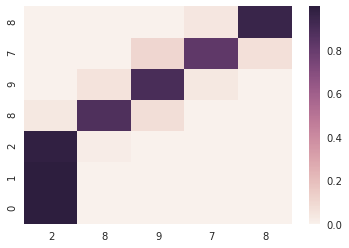

In [107]:
sb.heatmap(cm)